# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

This non-commercial license of GraphLab Create is assigned to jzhao59@illinois.edu and will expire on June 11, 2017. For commercial licensing options, visit https://dato.com/buy/.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1466878869.log


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [12]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.189876     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.209478     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.230253     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.256398     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.282983     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.305131     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [13]:
model_all.coefficients.print_rows(num_rows = 18)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [14]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [21]:
import numpy as np
rss = []
for l1_panalty in np.logspace(1, 7, num=13):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False, 
                                              l2_penalty=0., l1_penalty=l1_panalty)
    prediction = model.predict(validation)
    error = validation['price'] - prediction
    RSS = np.dot(error, error)
    rss.append(RSS)
    print l1_panalty, '\t', RSS

10.0 	6.25766285142e+14
31.6227766017 	6.25766285362e+14
100.0 	6.25766286058e+14
316.227766017 	6.25766288257e+14
1000.0 	6.25766295212e+14
3162.27766017 	6.25766317206e+14
10000.0 	6.25766386761e+14
31622.7766017 	6.25766606749e+14
100000.0 	6.25767302792e+14
316227.766017 	6.25769507644e+14
1000000.0 	6.25776517727e+14
3162277.66017 	6.25799062845e+14
10000000.0 	6.25883719085e+14


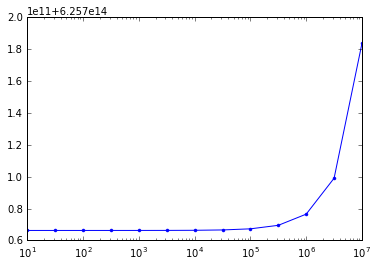

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(np.logspace(1, 7, num=13), rss, '.-')
plt.xscale('log')
plt.show()

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [32]:
l1_penalty = 10
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                        validation_set=None, verbose = False, 
                                        l2_penalty=0., l1_penalty=l1_penalty)
prediction = model.predict(testing)
error = testing['price'] - prediction
RSS = np.dot(error, error)
print RSS

1.56983602382e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [33]:
model.coefficients['value'].nnz()

18

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [36]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [37]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [ ]:
num = []
for l1_penalty in np.logspace(8, 10, num=20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False, 
                                              l2_penalty=0., l1_penalty=l1_penalty)
    num.append(model.coefficients['value'].nnz())

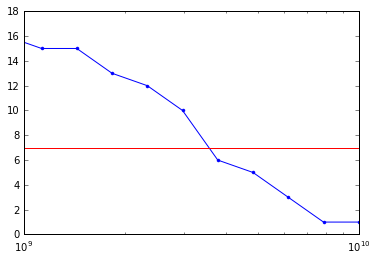

In [40]:
plt.figure()
plt.plot(np.logspace(8, 10, num=20), num, '.-')
plt.hold('on')
plt.plot(np.logspace(8, 10, num=20), [max_nonzeros]*len(np.logspace(8, 10, num=20)), 'r-')
plt.xlim([1e9, 1e10])
plt.xscale('log')
plt.show()

In [53]:
for i in range(len(num) - 1):
    if num[i] > max_nonzeros and num[i+1] < max_nonzeros:
        print 'minimum', np.logspace(8, 10, num=20)[i]
        
    if num[i] > max_nonzeros and num[i+1] < max_nonzeros:
        print 'maximum', np.logspace(8, 10, num=20)[i+1]

minimum 2976351441.63
maximum 3792690190.73


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [54]:
l1_penalty_min = 2976351441.63
l1_penalty_max = 3792690190.73

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [55]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [62]:
rss = []
num = []
for l1_panalty in l1_penalty_values:
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False, 
                                              l2_penalty=0., l1_penalty=l1_panalty)
    no = model.coefficients['value'].nnz()
    num.append(no)
    if no == max_nonzeros:
        prediction = model.predict(validation)
        error = validation['price'] - prediction
        RSS = np.dot(error, error)
        rss.append(RSS)
        print l1_panalty, '\t', RSS

3448968612.16 	1.04693748875e+15
3491933809.48 	1.05114762561e+15
3534899006.8 	1.05599273534e+15
3577864204.12 	1.06079953176e+15


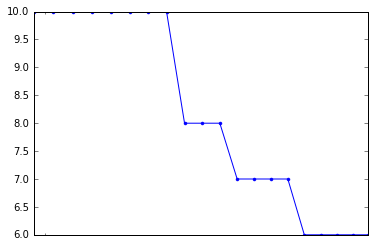

In [63]:
plt.figure()
plt.plot(l1_penalty_values, num, '.-')
plt.xscale('log')
plt.xlim([l1_penalty_min, l1_penalty_max])
plt.show()

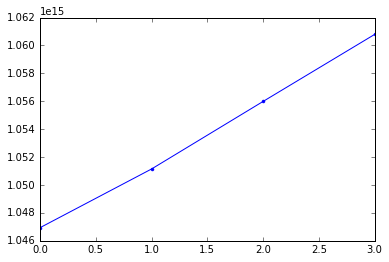

In [64]:
plt.figure()
plt.plot(rss, '.-')
plt.show()

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?